# Обработка данных

In [1]:
import pandas as pd
from matplotlib import pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


c:\users\asyarita\appdata\local\programs\python\python39\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Присвоим каждому типу движения номер

In [2]:
# стояние, ходьба, велосипед, лестница, бег, подъём, автомобиль, электросамокат, машина, метро

classes = {'тояни' : 0, 'месте' : 0, 'одьб' : 1, 'аг' : 1, 'ег' : 2, 'елоси' : 3, 'естн' : 4, 'одъ' : 4, 
           'втомо' : 5, 'ашин' : 5, 'метро' : 6, 'лектро' : 7, 'амок' : 8}

answers = {'стояние' : 0, 'ходьба' : 1, 'бег' : 2, 'велосипед' : 3, 'лестница' : 4, 
           'автомобиль' : 5, 'метро' : 6, 'электросамокат' : 7, 'самокат' : 8}

def get_action(name):
    for action in classes:
        if name.lower().find(action) != -1:
            return classes[action]
    return -1

Считывание данных

In [3]:
import os

path = 'mini-course-public' 

UnpreparedData, Data = [], []
UnpreparedTarget, Target = [], []

def read_files(comma):
    for directory in sorted(os.listdir(path)):
        directory_path = os.path.join(path, directory)
        if os.path.isfile(directory_path):
            with open(directory_path, 'r') as file_name:
                try:
                    df = pd.read_csv(file_name, delimiter=comma)
                    if df.shape[1] == 5:
                        UnpreparedData.append(df)
                        UnpreparedTarget.append(get_action(directory_path.split('\\')[-1]))
                except:
                    pass

read_files(';')
read_files(',')

In [4]:
import copy

Data = copy.deepcopy(UnpreparedData)
Target = copy.deepcopy(UnpreparedTarget)

len(Data), len(Target)

(1278, 1278)

Создадим `DataFrame`, хранящий в себе характеристики каждого трека

In [5]:
data = pd.DataFrame({'Target': Target})

В некоторых треках неправильно считан заголовок или называние столбца

In [6]:
for i in range(len(Data)):
    try:
        Data[i]['time']
    except KeyError:
        try:
            Data[i]['utime']
            Data[i].rename(columns={'utime': 'time'}, inplace=True)
        except:
            headers = Data[i].iloc[0]
            Data[i] = pd.DataFrame(Data[i].values[1:], columns=headers)

Обработаем данные

In [7]:
def get_amplitude(df):
    acceleration = (df.gFx ** 2 + df.gFy ** 2 + df.gFz ** 2) ** 0.5
    return acceleration.max() - acceleration.min()

def get_frequency(df):
    return df[df['time'] <= 1.0].shape[0]

def process_data(df):
    df = df.applymap(lambda x: str(x).replace(',', '.'))
    try:
        # приведение time к общему формату
        if str(df.iloc[0]['time']).find(':') != -1:
            df['time'] = df['time'].apply(lambda x: x.split(':')[-1])
            current_time = float(df.iloc[0]['time'])
            df['time'] = df['time'].apply(lambda x: float(x) - current_time)
        
        df['time'] = df['time'].astype(float)
        df['gFx'] = df['gFx'].astype(float)
        df['gFy'] = df['gFy'].astype(float)
        df['gFz'] = df['gFz'].astype(float)
    except KeyError:
        return df, -1, -1
    
    # получение частоты сбора данных
    freq = get_frequency(df)
    freq -= freq % 10    # округление
    if freq == 0:
        return df, -1, -1
    
    # обрезка начала и конца данных
    time = df.shape[0] // freq    # количество секунд в треке
    # оставляем только 10 секунд середины, так как некоторые треки очень короткие
    start = (time - 10) // 2 * freq
    end = -(time - 10) // 2 * freq    
    df = df[start:end]
    
    return df, get_amplitude(df), freq
    
Amplitude = []
Frequency = [] # для FFT
for i in range(len(Data)):
    Data[i], amplitude, frequency = process_data(Data[i])
    Amplitude.append(amplitude)
    Frequency.append(frequency)

len(Amplitude), len(Frequency)

(1278, 1278)

Добавим новую характеристику

In [8]:
# добавление характеристик Amplitude и Frequency
data['Amplitude'] = Amplitude
data['Frequency'] = Frequency
data.shape

(1278, 3)

Оставим только данные о треках, у которых вычислена амплитуда, частота и известен тип движения

In [9]:
# преобразуем основные данные
valid = [i for i in range(len(Data)) if not (math.isnan(Amplitude[i]) or 
                                             Amplitude[i] == -1 or 
                                             Frequency == -1 or 
                                             Target[i] == -1)]
Data = [Data[i] for i in valid]
Target = [Target[i] for i in valid]
Amplitude = [Amplitude[i] for i in valid]
Frequency = [Frequency[i] for i in valid]

# преобразуем таблицу
data = data[(data['Amplitude'].notna()) & 
            (data['Amplitude'] != -1) & 
            (data['Frequency'] != -1) & 
            (data['Target'] != -1)]
len(Data), len(Target), len(Amplitude), len(Frequency), data.shape

(1210, 1210, 1210, 1210, (1210, 3))

Приведём $x$, $y$ и $z$ к главным осям.

In [10]:
# поиск матрицы поворота
def rotation_matrix_from_vectors(vec1, vec2):
    norm_vec1 = (vec1 / numpy.linalg.norm(vec1)).reshape(3)
    norm_vec2 = (vec2 / numpy.linalg.norm(vec2)).reshape(3)
    cross_prod = numpy.cross(norm_vec1, norm_vec2)
    if any(cross_prod):
        scalar_prod = numpy.dot(norm_vec1, norm_vec2)
        cross_prod_norm = numpy.linalg.norm(cross_prod)
        k_mat = numpy.array([[0, -cross_prod[2], cross_prod[1]], 
                            [cross_prod[2], 0, -cross_prod[0]], 
                            [-cross_prod[1], cross_prod[0], 0]])
        return numpy.eye(3) + k_mat + k_mat.dot(k_mat) * ((1 - scalar_prod) / (cross_prod_norm ** 2))
    else:
        return numpy.eye(3)

# получение новых координат
def rotate(X, Y, Z, matrix):
    new_x, new_y, new_z = [], [], []
    for coord in zip(X, Y, Z):
        res = matrix.dot(coord)
        new_x.append(res[0])
        new_y.append(res[1])
        new_z.append(res[2])
    return new_x, new_y, new_z

# новые координаты
NewData = []
for df in Data:
    # вычисляем средний вектор ускорения по треку
    m_x = df['gFx'].values.mean() 
    m_y = df['gFy'].values.mean() 
    m_z = df['gFz'].values.mean() 
    # находим матрицу поворота
    vec1 = [m_x, m_y, m_z]
    vec2 = [0, 0, 1]
    matrix = rotation_matrix_from_vectors(vec1, vec2)
    # находим новые координаты
    new_x, new_y, new_z = rotate(df['gFx'].values, 
                                 df['gFy'].values, 
                                 df['gFz'].values, 
                                 matrix)
    # добавляем новые координаты в NewData
    NewData.append(pd.DataFrame({'gFx': new_x, 'gFy': new_y, 'gFz': new_z}))

len(NewData)

1210

Вычислим скорость и перемещение по каждому треку

In [11]:
import numpy as np

def integrate(arr):
    res = []
    s = 0
    for elem in arr:
        s += elem
        res.append(s)
    return res

def get_difference(arr):
    return max(arr) - min(arr)

Velocity = []
vel_amp = []
for i in range(len(NewData)):
    x = np.array([x_coord / Frequency[i] for x_coord in NewData[i]['gFx']])
    y = np.array([y_coord / Frequency[i] for y_coord in NewData[i]['gFy']])
    z = np.array([(z_coord - 1) / Frequency[i] for z_coord in NewData[i]['gFz']])
    acceleration = (x ** 2 + y ** 2 + z ** 2) ** 0.5
    
    # получение скорости
    Velocity.append(integrate(acceleration))
    # получение нужных характеристик
    vel_amp.append(get_difference(Velocity[i]))
    
data['VelocityAmplitude'] = vel_amp

len(vel_amp)

1210

Сделаем преобразование Фурье:

In [12]:
FFT_acc = []
for i in range(len(Data)):
    n = Data[i].shape[0]
    T = n / Frequency[i]
    
    # преобразование для данных по Acceleration
    f = (Data[i]['gFx'] ** 2 + Data[i]['gFy'] ** 2 + Data[i]['gFz'] ** 2) ** 0.5
    frq = (np.arange(n) / T)[:n // 2]
    F_acc = abs((np.fft.fft(f) / n)[:n // 2])
    
    # добавляем полученный результат в массив
    FFT_acc.append(F_acc)

Найдём точку пика и пик в преобразовании Фурье

In [13]:
X_max, Y_max = [], []
for i in range(len(Data)):
    ind = np.argmax(np.array(FFT_acc[i][1:])) + 1
    n = Data[i].shape[0]
    T = n / Frequency[i]  
    # добавляем значения в массив
    X_max.append((np.arange(n) / T)[ind])
    Y_max.append(FFT_acc[i][ind])
    
data['X_max'] = X_max
data['Y_max'] = Y_max

Нарисуем графики

Target                 1.000000
Amplitude              2.584761
Frequency            400.000000
VelocityAmplitude      6.065514
X_max                  1.497426
Y_max                  0.095161
Name: 11, dtype: float64

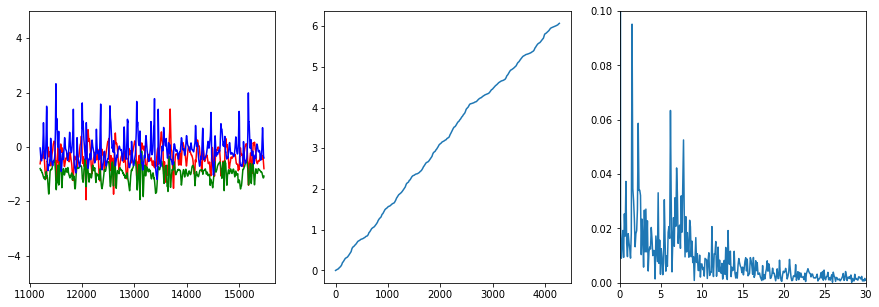

____________________________________________________________________________________________________


Target                 1.000000
Amplitude              2.520449
Frequency            400.000000
VelocityAmplitude      6.114801
X_max                  1.556777
Y_max                  0.100758
Name: 12, dtype: float64

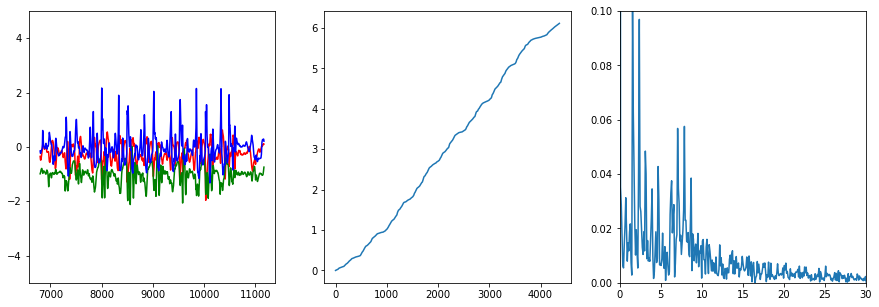

____________________________________________________________________________________________________


Target                 1.000000
Amplitude              2.235247
Frequency            400.000000
VelocityAmplitude      4.597895
X_max                  1.578825
Y_max                  0.129361
Name: 18, dtype: float64

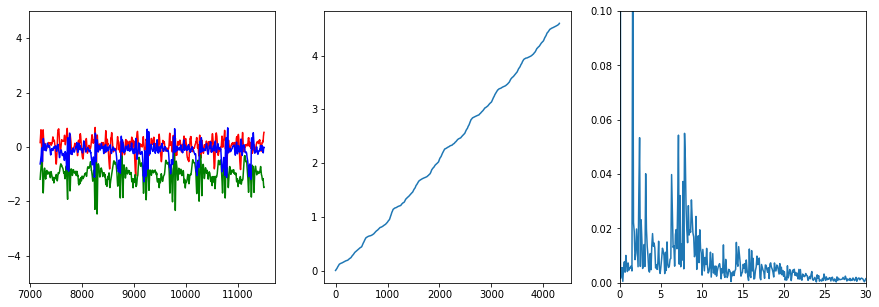

____________________________________________________________________________________________________


Target                 1.000000
Amplitude              2.248600
Frequency            400.000000
VelocityAmplitude      3.837597
X_max                  1.606046
Y_max                  0.097468
Name: 19, dtype: float64

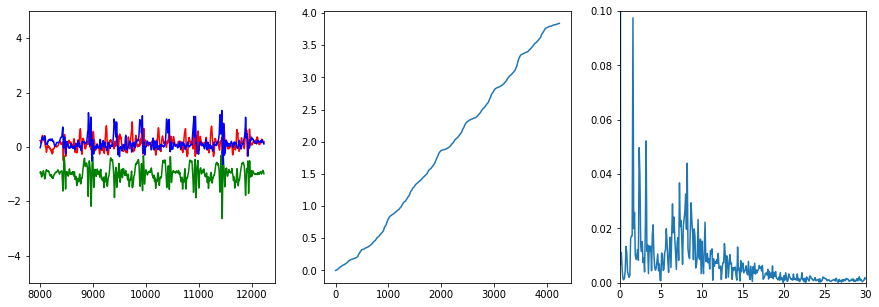

____________________________________________________________________________________________________


Target                 1.000000
Amplitude              2.566533
Frequency            250.000000
VelocityAmplitude      4.157758
X_max                  1.482800
Y_max                  0.107080
Name: 38, dtype: float64

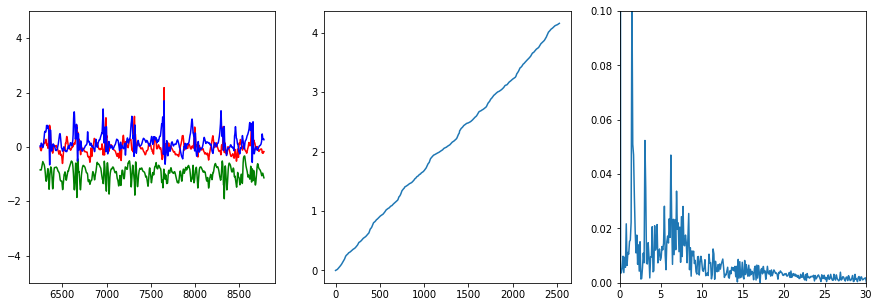

____________________________________________________________________________________________________


Target                 1.000000
Amplitude              2.254779
Frequency            250.000000
VelocityAmplitude      7.357117
X_max                  1.759259
Y_max                  0.222401
Name: 48, dtype: float64

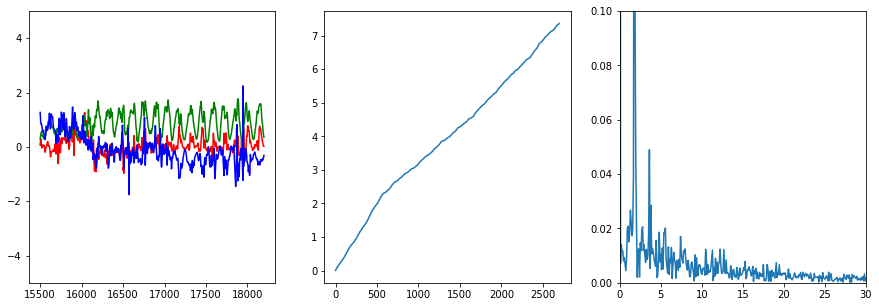

____________________________________________________________________________________________________


Target                 1.000000
Amplitude              1.858047
Frequency            250.000000
VelocityAmplitude      4.898588
X_max                  1.862015
Y_max                  0.245119
Name: 49, dtype: float64

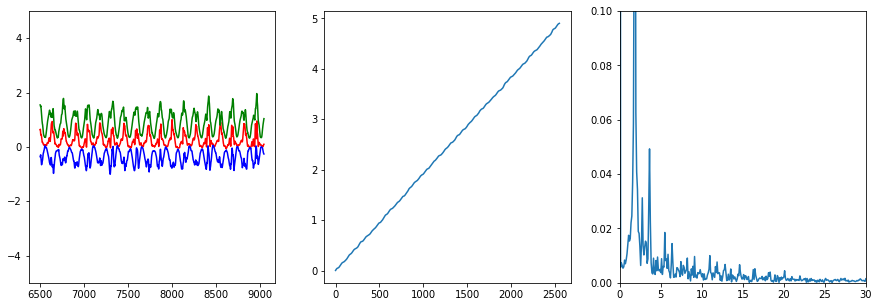

____________________________________________________________________________________________________


Target                 1.000000
Amplitude              1.996205
Frequency            250.000000
VelocityAmplitude      5.117190
X_max                  1.822717
Y_max                  0.313662
Name: 50, dtype: float64

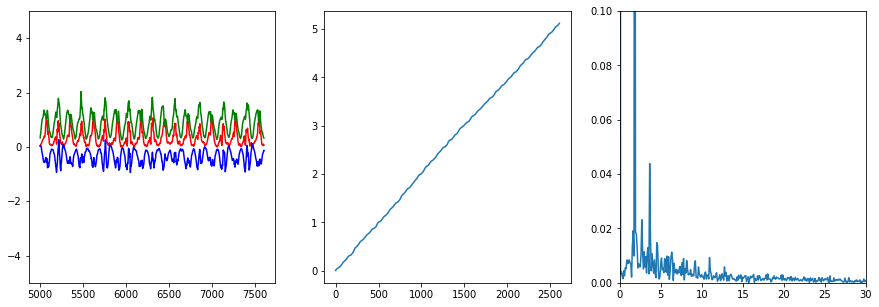

____________________________________________________________________________________________________


Target                 1.000000
Amplitude              2.028174
Frequency            250.000000
VelocityAmplitude      5.232138
X_max                  1.853225
Y_max                  0.320259
Name: 51, dtype: float64

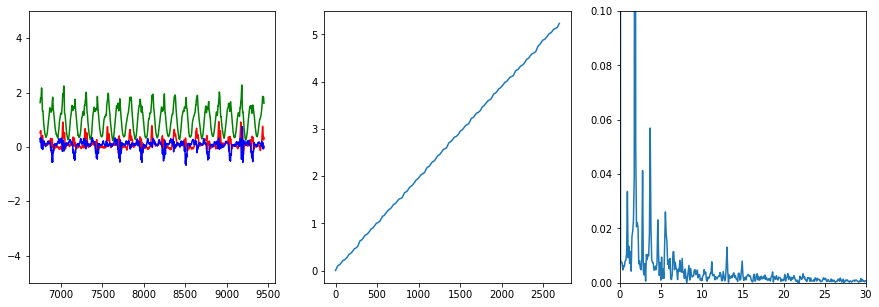

____________________________________________________________________________________________________


Target                 1.000000
Amplitude              1.492575
Frequency            100.000000
VelocityAmplitude      5.255531
X_max                  1.752678
Y_max                  0.251303
Name: 53, dtype: float64

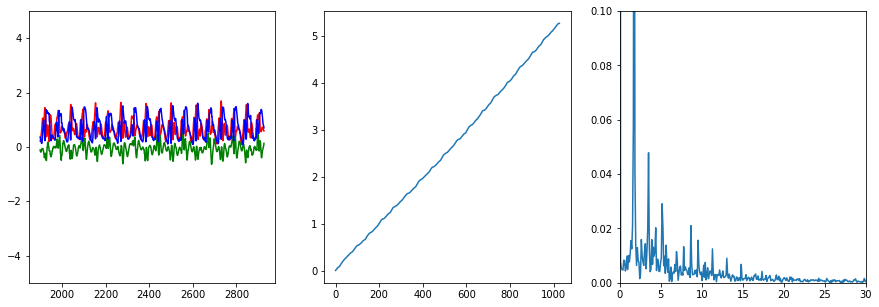

____________________________________________________________________________________________________


Target                 1.000000
Amplitude              4.066499
Frequency            500.000000
VelocityAmplitude      8.546696
X_max                  1.799924
Y_max                  0.145356
Name: 66, dtype: float64

In [14]:
try:
    current_type = 1

    for k in range(9, len(Data)):
        if Target[k] != current_type:
            continue
        display(data.iloc[k])
        fig, ((ax1, ax2, ax3))= plt.subplots(nrows=1, ncols=3, figsize=(15,5))

        # отрисовываем измерения по каждой оси
        ax1.plot(Data[k]['gFx'], color='r')
        ax1.plot(Data[k]['gFy'], color='g')
        ax1.plot(Data[k]['gFz'], color='b')
        ax1.set_ylim(-5, 5)
        # отрисовываем график скорости
        ax2.plot(Velocity[k])
        # отрисовываем FFT
        n = Data[k].shape[0]
        T = n / Frequency[k]    
        ax3.plot((np.arange(n) / T)[:n // 2], FFT_acc[k])
        ax3.set_xlim(0, 30)
        ax3.set_ylim(0, 0.1)

        plt.show()

        print('_' * 100)
except:
    pass

Посмотрим на средние знаячения характеристик

In [15]:
from colorama import Fore, Style

types = ['Стояние:', 'Ходьба:', 'Бег:', 'Велосипед:', 'Лестница:', 'Автомобиль:', 'Метро:', 'Электросамокат:']
features = ['Amplitude', 'VelocityAmplitude', 'X_max', 'Y_max']

def print_mean(name, feature):
    print(types[name], data[data['Target'] == name][feature].mean().round(5), sep=' ')

for feature in features:
    print(Fore.RED + feature, Style.RESET_ALL, sep='')
    Style.RESET_ALL
    for i in range(len(types)):
        print_mean(i, feature)
    print()

Amplitude
Стояние: 0.10439
Ходьба: 2.58746
Бег: 6.68178
Велосипед: 2.144
Лестница: 2.18784
Автомобиль: 0.66
Метро: 0.34874
Электросамокат: 1.91148

VelocityAmplitude
Стояние: 0.35774
Ходьба: 5.16233
Бег: 14.6322
Велосипед: 3.44447
Лестница: 3.84931
Автомобиль: 1.0232
Метро: 1.10512
Электросамокат: 2.25893

X_max
Стояние: 8.66856
Ходьба: 1.89641
Бег: 2.94871
Велосипед: 3.95038
Лестница: 1.66196
Автомобиль: 4.87969
Метро: 2.50102
Электросамокат: 6.28641

Y_max
Стояние: 0.00338
Ходьба: 0.14564
Бег: 0.42575
Велосипед: 0.05581
Лестница: 0.09149
Автомобиль: 0.01547
Метро: 0.00911
Электросамокат: 0.0363



# Анализ данных

### Критерий для стояния

In [16]:
def criteria_0(df, name):
    if name == -1:
        return df[(df['Amplitude'] < 0.35) & 
                  (df['Y_max'] < 0.03)].shape[0]
    return df[(df['Target'] == name) & 
              (df['Amplitude'] < 0.35) & 
              (df['Y_max'] < 0.03)].shape[0]

print('Всего стояния: ', data[(data['Target'] == 0)].shape[0])
print('Стояние: ', criteria_0(data, 0))
print('Всего найдено по критерию: ', criteria_0(data, -1), '\n')

# пересечения
print('Ходьба: ', criteria_0(data, 1))
print('Бег: ', criteria_0(data, 2))
print('Велосипед: ', criteria_0(data, 3))
print('Лестница: ', criteria_0(data, 4))
print('Автомобиль: ', criteria_0(data, 5))
print('Метро: ', criteria_0(data, 6))
print('Электросамокат: ', criteria_0(data, 7))

Всего стояния:  300
Стояние:  282
Всего найдено по критерию:  320 

Ходьба:  8
Бег:  0
Велосипед:  0
Лестница:  13
Автомобиль:  4
Метро:  7
Электросамокат:  0


### Критерий для бега

In [17]:
def criteria_2(df, name):
    if name == -1:
        return df[(df['Amplitude'] > 3) & 
                  (df['Y_max'] > 0.15) & 
                  (df['VelocityAmplitude'] > 8)].shape[0]
    return df[(df['Target'] == name) & 
              (df['Amplitude'] > 3) & 
              (df['Y_max'] > 0.15) & 
              (df['VelocityAmplitude'] > 8)].shape[0]

print('Всего бега: ', data[(data['Target'] == 2)].shape[0])
print('Бег: ', criteria_2(data, 2))
print('Всего найдено по критерию: ', criteria_2(data, -1), '\n')

# пересечения
print('Стояние: ', criteria_2(data, 0))
print('Ходьба: ', criteria_2(data, 1))
print('Велосипед: ', criteria_2(data, 3))
print('Лестница: ', criteria_2(data, 4))
print('Автомобиль: ', criteria_2(data, 5))
print('Метро: ', criteria_2(data, 6))
print('Электросамокат: ', criteria_2(data, 7))

Всего бега:  236
Бег:  209
Всего найдено по критерию:  241 

Стояние:  0
Ходьба:  32
Велосипед:  0
Лестница:  0
Автомобиль:  0
Метро:  0
Электросамокат:  0


### Критерий для метро

In [18]:
def criteria_6(df, name):
    if name == -1:
        return df[(df['Y_max'] < 0.01)].shape[0]
    return df[(df['Target'] == name) & 
              (df['Y_max'] < 0.01)].shape[0]

print('Всего метро: ', data[(data['Target'] == 6)].shape[0])
print('Метро: ', criteria_6(data, 6))
print('Всего найдено по критерию: ', criteria_6(data, -1), '\n')

# пересечения
print('Стояние: ', criteria_6(data, 0))
print('Ходьба: ', criteria_6(data, 1))
print('Бег: ', criteria_6(data, 2))
print('Велосипед: ', criteria_6(data, 3))
print('Лестница: ', criteria_6(data, 4))
print('Автомобиль: ', criteria_6(data, 5))
print('Электросамокат: ', criteria_6(data, 7))

Всего метро:  13
Метро:  9
Всего найдено по критерию:  302 

Стояние:  276
Ходьба:  2
Бег:  0
Велосипед:  1
Лестница:  6
Автомобиль:  8
Электросамокат:  0


### Критерий для автомобиля

In [19]:
def criteria_5(df, name):
    if name == -1:
        return df[(df['Y_max'] < 0.02) &
                  (df['Amplitude'] < 2)].shape[0]
    return df[(df['Target'] == name) &
              (df['Y_max'] < 0.02) &
              (df['Amplitude'] < 2)].shape[0]

print('Всего автомобилей: ', data[(data['Target'] == 5)].shape[0])
print('Автомобиль: ', criteria_5(data, 5))
print('Всего найдено по критерию: ', criteria_5(data, -1), '\n')

# пересечения
print('Стояние: ', criteria_5(data, 0))
print('Ходьба: ', criteria_5(data, 1))
print('Бег: ', criteria_5(data, 2))
print('Велосипед: ', criteria_5(data, 3))
print('Лестница: ', criteria_5(data, 4))
print('Метро: ', criteria_5(data, 6))
print('Электросамокат: ', criteria_5(data, 7))

Всего автомобилей:  31
Автомобиль:  27
Всего найдено по критерию:  351 

Стояние:  285
Ходьба:  8
Бег:  0
Велосипед:  7
Лестница:  6
Метро:  12
Электросамокат:  0


### Критерий для электросамоката

In [20]:
def criteria_7(df, name):
    if name == -1:
        return df[(data['X_max'] > 4.5) &
                  (data['Y_max'] < 0.06)].shape[0]
    return df[(df['Target'] == name) &
              (df['X_max'] > 4.5) & 
              (df['Y_max'] < 0.06)].shape[0]

print('Всего электросамокатов: ', data[(data['Target'] == 7)].shape[0])
print('Электросамокат: ', criteria_7(data, 7))
print('Всего найдено по критерию: ', criteria_7(data, -1), '\n')

# пересечения
print('Стояние: ', criteria_7(data, 0))
print('Ходьба: ', criteria_7(data, 1))
print('Бег: ', criteria_7(data, 2))
print('Велосипед: ', criteria_7(data, 3))
print('Лестница: ', criteria_7(data, 4))
print('Автомобиль: ', criteria_7(data, 3))
print('Метро: ', criteria_7(data, 6))

Всего электросамокатов:  13
Электросамокат:  11
Всего найдено по критерию:  222 

Стояние:  185
Ходьба:  1
Бег:  0
Велосипед:  8
Лестница:  0
Автомобиль:  8
Метро:  1


### Критерий для велосипеда

In [21]:
def criteria_3(df, name):
    if name == -1:
        return df[((df['X_max'] < 1) | (df['X_max'] > 2.5)) &
                  (df['Y_max'] < 0.15)].shape[0]
    return df[(df['Target'] == name) &
              ((df['X_max'] < 1) | (df['X_max'] > 2.5)) &
              (df['Y_max'] < 0.15)].shape[0]

print('Всего велосипеда: ', data[(data['Target'] == 3)].shape[0])
print('Велосипед: ', criteria_3(data, 3))
print('Всего найдено по критерию: ', criteria_3(data, -1), '\n')

# пересечения
print('Стояние: ', criteria_3(data, 0))
print('Ходьба: ', criteria_3(data, 1))
print('Бег: ', criteria_3(data, 2))
print('Лестница: ', criteria_3(data, 4))
print('Автомобиль: ', criteria_3(data, 3))
print('Метро: ', criteria_3(data, 6))
print('Электросамокат: ', criteria_3(data, 7))

Всего велосипеда:  56
Велосипед:  50
Всего найдено по критерию:  444 

Стояние:  282
Ходьба:  38
Бег:  7
Лестница:  23
Автомобиль:  50
Метро:  2
Электросамокат:  12


### Критерий для лестницы

In [22]:
def criteria_4(df, name):
    if name == -1:
        return df[(df['Y_max'] < 0.1) & 
                  (df['VelocityAmplitude'] < 5.5)].shape[0]
    return df[(df['Target'] == name) &
              (df['Y_max'] < 0.1) & 
              (df['VelocityAmplitude'] < 5.5)].shape[0]

print('Всего лестницы: ', data[(data['Target'] == 4)].shape[0])
print('Лестница: ', criteria_4(data, 4))
print('Всего найдено по критерию: ', criteria_4(data, -1), '\n')

# пересечения
print('Стояние: ', criteria_4(data, 0))
print('Ходьба: ', criteria_4(data, 1))
print('Бег: ', criteria_4(data, 2))
print('Велосипед: ', criteria_4(data, 3))
print('Автомобиль: ', criteria_4(data, 5))
print('Метро: ', criteria_4(data, 6))
print('Электросамокат: ', criteria_4(data, 7))

Всего лестницы:  231
Лестница:  136
Всего найдено по критерию:  633 

Стояние:  299
Ходьба:  78
Бег:  3
Велосипед:  48
Автомобиль:  31
Метро:  13
Электросамокат:  13


# Получение предсказания

In [23]:
def get_prediction(df):
    if (df['Amplitude'] < 0.35) and (df['Y_max'] < 0.03):
        return 0 #стояние
    if (df['Amplitude'] > 3) and (df['Y_max'] > 0.15) and (df['VelocityAmplitude'] > 8):
        return 2 #бег
    if df['Y_max'] < 0.01:
        return 6 # метро
    if (df['Y_max'] < 0.02) and (df['Amplitude'] < 2):
        return 5 # автомобиль
    if (df['X_max'] > 4.5) and (df['Y_max'] < 0.06):
        return 7 # электросамокат
    if ((df['X_max'] < 1) or (df['X_max'] > 2.5)) and (df['Y_max'] < 0.15):
        return 3 # велосипед
    if (df['Y_max'] < 0.1) and (df['VelocityAmplitude'] < 5.5):
        return 4 # лестница
    return 1 #ходьба

prediction = data.apply(lambda x: get_prediction(x), axis=1)

In [24]:
Res = pd.DataFrame({'track_num' : np.arange(data.shape[0]), 'answer' : data['Target'], 'action' : prediction})
Res.shape, len(Target), len(Data), data.shape, prediction.shape

((1210, 3), 1210, 1210, (1210, 6), (1210,))

In [25]:
from sklearn.metrics import accuracy_score

accuracy_score(Res['answer'], Res['action'])

0.7206611570247934

In [26]:
import random

Res.reset_index(drop=True, inplace=True)

ind_0 = random.sample(Res[Res.answer == 0].index.tolist(), 32)
ind_1 = random.sample(Res[Res.answer == 1].index.tolist(), 32)
ind_2 = random.sample(Res[Res.answer == 2].index.tolist(), 32)
ind_3 = random.sample(Res[Res.answer == 3].index.tolist(), 32)
ind_4 = random.sample(Res[Res.answer == 4].index.tolist(), 32)
ind_5 = random.sample(Res[Res.answer == 5].index.tolist(), 6)
ind_6 = random.sample(Res[Res.answer == 6].index.tolist(), 6)
ind_7 = random.sample(Res[Res.answer == 7].index.tolist(), 6)

ind_balanced = ind_0 + ind_1 + ind_2 + ind_3 + ind_4 + ind_5 + ind_6 + ind_7 

Res_balanced = Res.iloc[ind_balanced]
accuracy_score(Res_balanced['answer'], Res_balanced['action'])

0.7528089887640449

In [27]:
Res_balanced['answer'].value_counts(), Res_balanced['action'].value_counts()

(0    32
 1    32
 2    32
 3    32
 4    32
 5     6
 6     6
 7     6
 Name: answer, dtype: int64,
 1    41
 0    40
 2    31
 3    27
 4    23
 5     7
 7     5
 6     4
 Name: action, dtype: int64)